# Кластеризация

Метод ближайшего соседа и расстояние Минковского

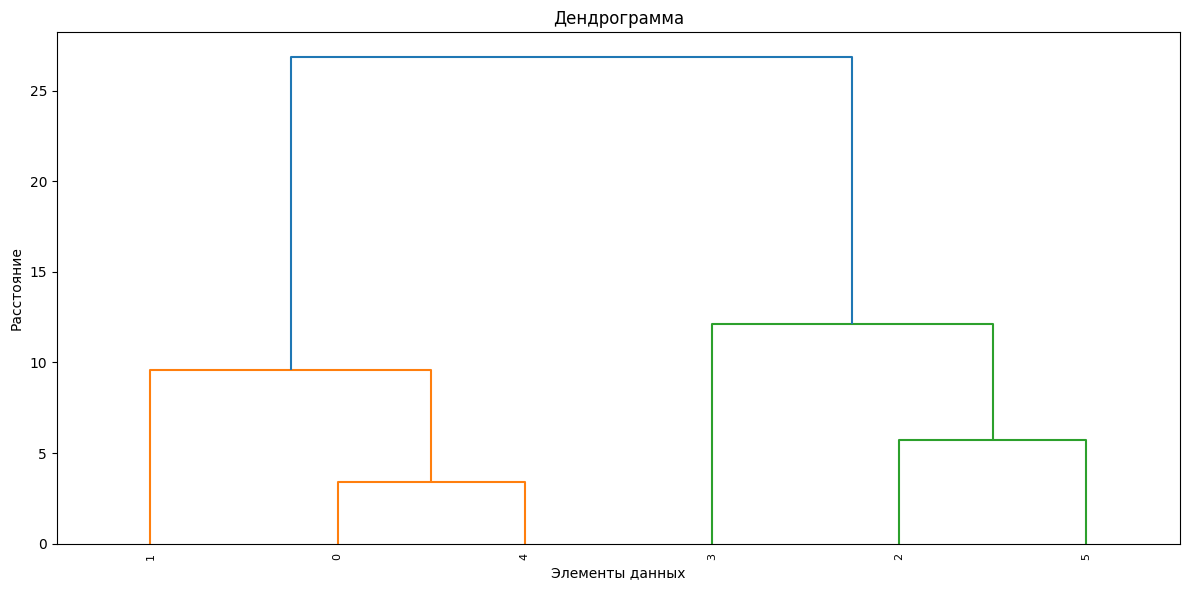

In [11]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import plotly.figure_factory as ff


class HierarchicalClustering:
    def __init__(self, data, p=2, method='single'):
        """
        Инициализация объекта для иерархической кластеризации.

        :param data: Данные для кластеризации (numpy array).
        :param p: Параметр для метрики Минковского (по умолчанию 2, что соответствует евклидову расстоянию).
        :param method: Метод кластеризации (по умолчанию 'single').
        """
        self.data = data
        self.p = p
        self.method = method
        self.distance_matrix = None
        self.Z = []  # Linkage matrix
        self.labels = None

    def minkowski_distance(self, point1, point2):
        """Вычисление расстояния Минковского между двумя точками."""
        return np.sum(np.abs(point1 - point2) ** self.p) ** (1 / self.p)

    def calculate_distances(self):
        """Вычисление матрицы попарных расстояний."""
        n = len(self.data)
        self.distance_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                dist = self.minkowski_distance(self.data[i], self.data[j])
                self.distance_matrix[i, j] = dist
                self.distance_matrix[j, i] = dist

    def perform_clustering(self):
        """Выполнение иерархической кластеризации."""
        if self.distance_matrix is None:
            raise ValueError("Расстояния не вычислены. Сначала выполните calculate_distances.")

        n = len(self.data)
        clusters = [[i] for i in range(n)]  # Each point starts as its own cluster
        current_cluster_id = n  # IDs for new merged clusters

        while len(clusters) > 1:
            min_dist = float('inf')
            merge_pair = (-1, -1)

            # Find the closest pair of clusters
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = self._calculate_linkage_distance(clusters[i], clusters[j])
                    if dist < min_dist:
                        min_dist = dist
                        merge_pair = (i, j)

            # Merge the closest clusters
            i, j = merge_pair
            new_cluster = clusters[i] + clusters[j]
            clusters.append(new_cluster)

            # Record the merge in the linkage matrix
            self.Z.append([clusters[i][0], clusters[j][0], min_dist, len(new_cluster)])

            # Remove the merged clusters
            del clusters[max(i, j)]
            del clusters[min(i, j)]

            # Update cluster IDs
            current_cluster_id += 1

        # Convert Z to the correct format
        self.Z = self._fix_linkage_matrix()

    def _fix_linkage_matrix(self):
        """Fix the linkage matrix to conform to scipy's expected format."""
        n = len(self.data)
        cluster_id_map = {i: i for i in range(n)}  # Map original IDs to new IDs
        fixed_Z = []

        for i, (c1, c2, dist, size) in enumerate(self.Z):
            # Map old cluster IDs to new IDs
            new_c1 = cluster_id_map[c1]
            new_c2 = cluster_id_map[c2]

            # Assign a new ID to the merged cluster
            new_cluster_id = n + i
            cluster_id_map[c1] = new_cluster_id
            cluster_id_map[c2] = new_cluster_id

            # Append the fixed row to the linkage matrix
            fixed_Z.append([new_c1, new_c2, dist, size])

        return np.array(fixed_Z)

    def _calculate_linkage_distance(self, cluster1, cluster2):
        """Вычисление расстояния между двумя кластерами в зависимости от метода."""
        if self.method == 'single':
            return self._single_linkage(cluster1, cluster2)
        elif self.method == 'complete':
            return self._complete_linkage(cluster1, cluster2)
        elif self.method == 'average':
            return self._average_linkage(cluster1, cluster2)
        else:
            raise ValueError(f"Неизвестный метод: {self.method}")

    def _single_linkage(self, cluster1, cluster2):
        """Минимальное расстояние между элементами двух кластеров."""
        min_dist = float('inf')
        for i in cluster1:
            for j in cluster2:
                dist = self.distance_matrix[i, j]
                if dist < min_dist:
                    min_dist = dist
        return min_dist

    def _complete_linkage(self, cluster1, cluster2):
        """Максимальное расстояние между элементами двух кластеров."""
        max_dist = -float('inf')
        for i in cluster1:
            for j in cluster2:
                dist = self.distance_matrix[i, j]
                if dist > max_dist:
                    max_dist = dist
        return max_dist

    def _average_linkage(self, cluster1, cluster2):
        """Среднее расстояние между элементами двух кластеров."""
        total_dist = 0
        count = 0
        for i in cluster1:
            for j in cluster2:
                total_dist += self.distance_matrix[i, j]
                count += 1
        return total_dist / count

    def get_cluster_labels(self, t):
        """Получение меток кластеров для заданного порога."""
        if self.Z is None:
            raise ValueError("Кластеризация не выполнена. Сначала выполните perform_clustering.")
        n = len(self.data)
        labels = np.arange(n)
        for i, (c1, c2, dist, _) in enumerate(self.Z):
            if dist <= t:
                labels[labels == c1] = n + i
                labels[labels == c2] = n + i
        self.labels = labels
        return labels

    def plot_dendrogram(self, labels=None, truncate_mode=None, p=30):
        """
        Построение дендрограммы с использованием scipy.cluster.hierarchy.dendrogram.
        
        :param labels: Optional list of labels (e.g., movie titles) to display on the x-axis.
        :param truncate_mode: Truncation mode ('lastp', 'level', or None).
        :param p: Number of bottom levels to show if truncate_mode='lastp'.
        """
        if self.Z is None:
            raise ValueError("Кластеризация не выполнена. Сначала выполните perform_clustering.")
        
        plt.figure(figsize=(12, 6))
        dendrogram(
            self.Z,
            labels=labels,
            leaf_rotation=90,
            leaf_font_size=8,
            truncate_mode=truncate_mode,  # Truncate the dendrogram
            p=p                          # Number of bottom levels to show
        )
        plt.title('Дендрограмма')
        plt.xlabel('Элементы данных')
        plt.ylabel('Расстояние')
        plt.tight_layout()
        plt.show()

    def plot_interactive_dendrogram(self, labels=None):
        """
        Построение интерактивной дендрограммы с использованием Plotly.
        
        :param labels: Optional list of labels (e.g., movie titles) to display on the x-axis.
        """
        if self.Z is None:
            raise ValueError("Кластеризация не выполнена. Сначала выполните perform_clustering.")
        
        fig = ff.create_dendrogram(
            self.data,
            labels=labels,
            linkagefun=lambda x: self.Z
        )
        fig.update_layout(
            title="Интерактивная Дендрограмма",
            xaxis_title="Элементы данных",
            yaxis_title="Расстояние",
            width=1200,
            height=600
        )
        fig.show()


# Данные
data = np.array([
    [11.5, 6.9],
    [20.1, 11.1],
    [34.2, 21.3],
    [22.1, 20.5],
    [13.4, 9.7],
    [29.4, 18.2]
])

hc = HierarchicalClustering(data, p=2, method='complete')
hc.calculate_distances()
hc.perform_clustering()
hc.plot_dendrogram()

# Реализация на SciPy (для проверки)

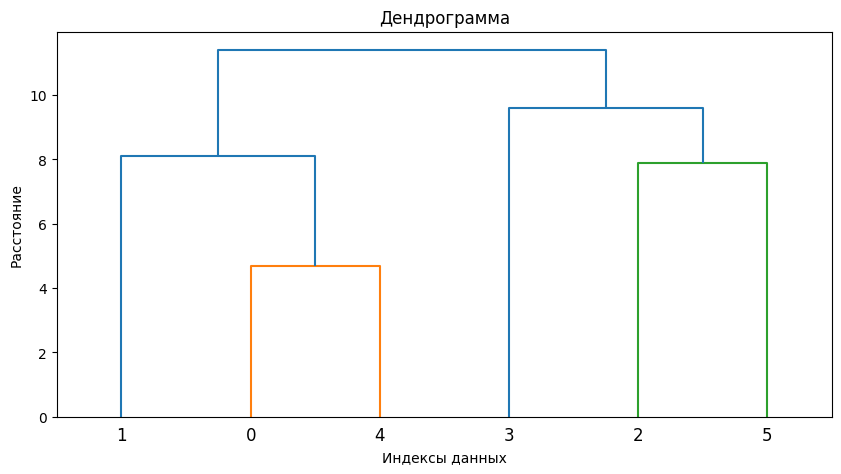

In [12]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

class SciPyHierarchicalClustering:
    def __init__(self, data, p=2, method='single'):
        """
        Инициализация объекта для иерархической кластеризации.

        :param data: Данные для кластеризации (numpy array).
        :param p: Параметр для метрики Минковского (по умолчанию 2, что соответствует евклидову расстоянию).
        :param method: Метод кластеризации (по умолчанию 'single').
        """
        self.data = data
        self.p = p
        self.method = method
        self.distances = None
        self.distance_matrix = None
        self.Z = None
        self.labels = None

    def calculate_distances(self):
        """Вычисление попарных расстояний между точками с использованием scipy."""
        self.distances = pdist(self.data, metric='minkowski', p=1)
        self.distance_matrix = squareform(self.distances)

    def perform_clustering(self):
        """Выполнение иерархической кластеризации с использованием scipy."""
        if self.distances is None:
            raise ValueError("Расстояния не вычислены. Сначала выполните calculate_distances.")
        self.Z = linkage(self.distances, method=self.method)

    def get_cluster_labels(self, t):
        """Получение меток кластеров для заданного порога с использованием scipy."""
        if self.Z is None:
            raise ValueError("Кластеризация не выполнена. Сначала выполните perform_clustering.")
        self.labels = fcluster(self.Z, t, criterion='distance')
        return self.labels

    def plot_dendrogram(self):
        """Построение дендрограммы."""
        if self.Z is None:
            raise ValueError("Кластеризация не выполнена. Сначала выполните perform_clustering.")
        plt.figure(figsize=(10, 5))
        dendrogram(self.Z)
        plt.title('Дендрограмма')
        plt.xlabel('Индексы данных')
        plt.ylabel('Расстояние')
        plt.show()

data = np.array([
    [11.5, 6.9],
    [20.1, 11.1],
    [34.2, 21.3],
    [22.1, 20.5],
    [13.4, 9.7],
    [29.4, 18.2]
])

scipy_hc = SciPyHierarchicalClustering(data)
scipy_hc.calculate_distances()
scipy_hc.perform_clustering()
scipy_hc.plot_dendrogram()

In [13]:
def calculate_functional(data, labels):
    """
    Вычисление функционала Q(C) по формуле.

    :param data: Данные (numpy array, shape (n_samples, n_features)).
    :param labels: Метки кластеров (numpy array, shape (n_samples,)).
    :return: Значение функционала Q(C).
    """
    unique_labels = np.unique(labels)
    functional_value = 0.0

    for label in unique_labels:
        cluster_points = data[labels == label]  # Точки в текущем кластере
        centroid = np.mean(cluster_points, axis=0)  # Центроид кластера
        distances = np.sum((cluster_points - centroid) ** 2, axis=1)  # Квадраты расстояний до центроида
        functional_value += np.sum(distances)  # Суммируем для кластера

    return functional_value

# Получение меток кластеров для заданного порога
threshold = 10  # Example threshold
labels = hc.get_cluster_labels(threshold)

# Вычисление функционала Q(C)
functional_value = calculate_functional(data, labels)
print(f"Значение функционала Q(C): {functional_value}")

Значение функционала Q(C): 66.2916666666667


# Тест с датасетом Kaggle

In [14]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = "netflix_movies_detailed_up_to_2025.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average,budget,revenue
0,10192,Movie,Shrek Forever After,Mike Mitchell,"Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...",United States of America,2010-05-16,2010,6.380,NaN,"Comedy, Adventure, Fantasy, Animation, Family",en,A bored and domesticated Shrek pacts with deal...,203.893,7449,6.380,165000000,752600867
1,27205,Movie,Inception,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","United Kingdom, United States of America",2010-07-15,2010,8.369,NaN,"Action, Science Fiction, Adventure",en,"Cobb, a skilled thief who commits corporate es...",156.242,37119,8.369,160000000,839030630
2,12444,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,"Daniel Radcliffe, Emma Watson, Rupert Grint, T...","United Kingdom, United States of America",2010-11-17,2010,7.744,NaN,"Adventure, Fantasy",en,"Harry, Ron and Hermione walk away from their l...",121.191,19327,7.744,250000000,954305868
3,38757,Movie,Tangled,"Byron Howard, Nathan Greno","Mandy Moore, Zachary Levi, Donna Murphy, Ron P...",United States of America,2010-11-24,2010,7.600,NaN,"Animation, Family, Adventure",en,"Feisty teenager Rapunzel, who has long and mag...",111.762,11638,7.600,260000000,592461732
4,10191,Movie,How to Train Your Dragon,"Chris Sanders, Dean DeBlois","Jay Baruchel, Gerard Butler, Craig Ferguson, A...",United States of America,2010-03-18,2010,7.800,NaN,"Fantasy, Adventure, Animation, Family",en,As the son of a Viking leader on the cusp of m...,110.044,13259,7.800,165000000,494879471


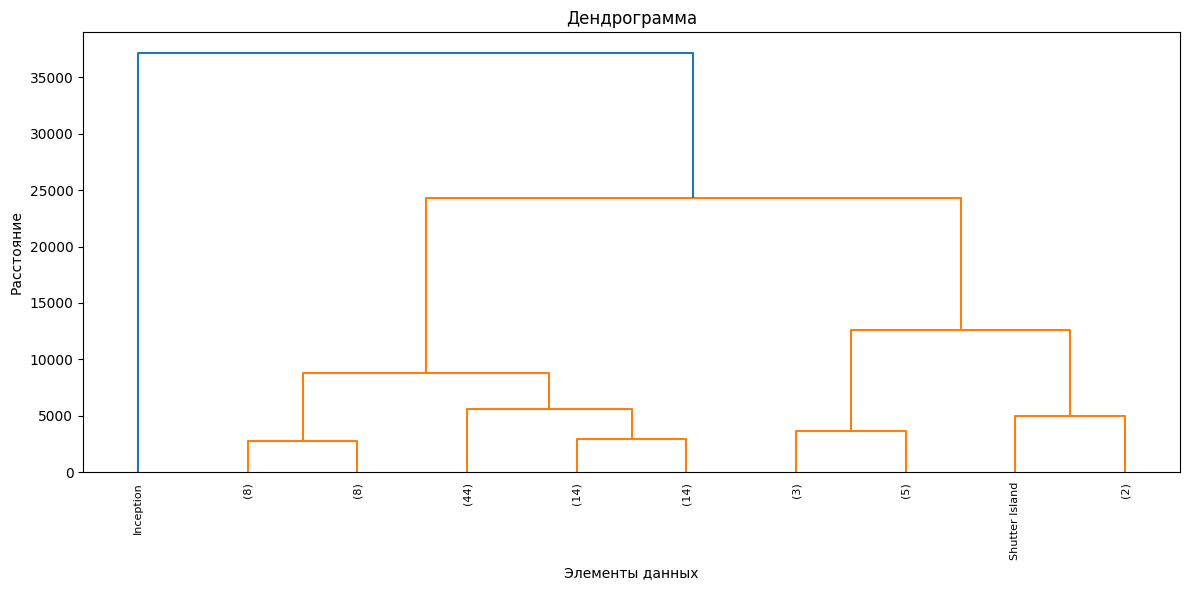

In [15]:
# Step 1: Load the data
file_path = "netflix_movies_detailed_up_to_2025.csv"  # Replace with the actual path to your file
df = pd.read_csv(file_path)
df = df.iloc[:100]

# Step 2: Preprocess the data
# Select relevant columns and drop rows with missing values
data = df[['vote_count', 'vote_average']].dropna().values
titles = df.loc[df['vote_count'].notna() & df['vote_average'].notna(), 'title'].tolist()

# Step 3: Perform hierarchical clustering
hc = HierarchicalClustering(data, p=2, method='complete')
hc.calculate_distances()
hc.perform_clustering()
hc.plot_dendrogram(labels=titles, truncate_mode='lastp', p=10)
hc.plot_interactive_dendrogram(labels=titles)